In [13]:
import itertools
from copy import deepcopy as copy
from functools import reduce
from itertools import product
from operator import itemgetter

import cvxpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy
from numpy.linalg import matrix_rank as rank
from scipy.linalg import block_diag, fractional_matrix_power
from utils.Adversary import Adversary
from utils.Conversions import hamming_dist as dist
from utils.Conversions import to_str, visualize
from utils.Problems import Problem, exact_k, threshold_k
import random
from utils.Solvers import (
    adv_solver,
    instance_mask,
    ket,
    partial,
    span_solver,
    type_mask,
)

def pad_problem(problem, pad=1):
    no_instances = [x + (0,) * pad for x in problem.no_instances]
    yes_instances = [y + (1,) * pad for y in problem.yes_instances]
    return Problem(no_instances, yes_instances) 

def hide_instance(indicators, instance, hider):
    assert len(indicators) == len(instance) + len(hider) 
    hidden_instance = []
    instance_index = 0
    hider_index = 0
    for i in range(len(indicators)):
        if indicators[i] == 1:
            hidden_instance.append(instance[instance_index])
            instance_index += 1
        else:
            hidden_instance.append(hider[hider_index])
            hider_index += 1
    return tuple(indicators + hidden_instance)
    
def hide_problem(problem, hidden_len=None, hider_bank=None):
    n = problem.n
    if hidden_len == None:
        hidden_len = n**2
    if hider_bank == None:
        hider_bank = list(itertools.product(*[[0,1]]*(hidden_len - n)))
    no_instances = []
    yes_instances = []
    indicator_strings = []
    for one_indices in itertools.combinations(range(hidden_len), n):
        indicator_strings.append([1 if i in one_indices else 0 for i in range(hidden_len)])
    indicator_strings.sort()
    # print('indicators', indicator _strings)
    for new_instances, instances in zip([no_instances, yes_instances], [problem.no_instances, problem.yes_instances]):
        for instance in instances:
            for indicators in indicator_strings:
                for hider in hider_bank:
                    new_instances.append(hide_instance(indicators, instance, hider))
    return Problem(no_instances, yes_instances)

def all_bitstrings(n):
    return list(itertools.product(*[(0,1)]*n))

def string_equality(n):
    strings = all_bitstrings(n)
    no_instances = [x + x for x in strings]
    yes_instances = []
    for x in strings:
        for i in range(n):
            y = list(x)
            y[i] = (x[i] + 1) % 2
            yes_instances.append(x + tuple(y))
    return Problem(no_instances, yes_instances)
def longest_stretch(x):
    zero_count = 0
    max_count = 0
    for char in x:
        if char == 0:
            zero_count += 1
            if zero_count > max_count:
                max_count = zero_count
        else:
            zero_count = 0
    return max_count

def zeros_in_a_row(n, k):
    strings = all_bitstrings(n)
    no_instances = []
    yes_instances = []

    for x in strings:
        zero_count = longest_stretch(x)
        if zero_count == k-1:
            no_instances.append(x)
        elif zero_count == k:
            yes_instances.append(x)
    return Problem(no_instances, yes_instances)



In [15]:
n = 3
k = 2
prob = zeros_in_a_row(n,k)
print(prob)
hidden_prob = hide_problem(prob, hidden_len= 1+prob.n)
print(hidden_prob)

No:[(0, 1, 0), (0, 1, 1), (1, 0, 1), (1, 1, 0)]
Yes:[(0, 0, 1), (1, 0, 0)]
No:[(0, 1, 1, 1, 0, 0, 1, 0), (0, 1, 1, 1, 0, 0, 1, 1), (0, 1, 1, 1, 0, 1, 0, 1), (0, 1, 1, 1, 0, 1, 1, 0), (0, 1, 1, 1, 1, 0, 1, 0), (0, 1, 1, 1, 1, 0, 1, 1), (0, 1, 1, 1, 1, 1, 0, 1), (0, 1, 1, 1, 1, 1, 1, 0), (1, 0, 1, 1, 0, 0, 1, 0), (1, 0, 1, 1, 0, 0, 1, 1), (1, 0, 1, 1, 0, 1, 1, 0), (1, 0, 1, 1, 0, 1, 1, 1), (1, 0, 1, 1, 1, 0, 0, 1), (1, 0, 1, 1, 1, 0, 1, 0), (1, 0, 1, 1, 1, 1, 0, 1), (1, 0, 1, 1, 1, 1, 1, 0), (1, 1, 0, 1, 0, 1, 0, 0), (1, 1, 0, 1, 0, 1, 0, 1), (1, 1, 0, 1, 0, 1, 1, 0), (1, 1, 0, 1, 0, 1, 1, 1), (1, 1, 0, 1, 1, 0, 0, 1), (1, 1, 0, 1, 1, 0, 1, 1), (1, 1, 0, 1, 1, 1, 0, 0), (1, 1, 0, 1, 1, 1, 1, 0), (1, 1, 1, 0, 0, 1, 0, 0), (1, 1, 1, 0, 0, 1, 0, 1), (1, 1, 1, 0, 0, 1, 1, 0), (1, 1, 1, 0, 0, 1, 1, 1), (1, 1, 1, 0, 1, 0, 1, 0), (1, 1, 1, 0, 1, 0, 1, 1), (1, 1, 1, 0, 1, 1, 0, 0), (1, 1, 1, 0, 1, 1, 0, 1)]
Yes:[(0, 1, 1, 1, 0, 0, 0, 1), (0, 1, 1, 1, 0, 1, 0, 0), (0, 1, 1, 1, 1, 0, 0, 1), (0, 1,

In [16]:
adv, M = adv_solver(prob)
adv_hidden, M_hidden = adv_solver(hidden_prob)

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Jul 28 02:08:19 PM: Your problem has 42 variables, 151 constraints, and 0 parameters.
(CVXPY) Jul 28 02:08:19 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 28 02:08:19 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 28 02:08:19 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 28 02:08:19 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 28 02:08:19 PM: Compiling problem (target solver=MOSEK).
(

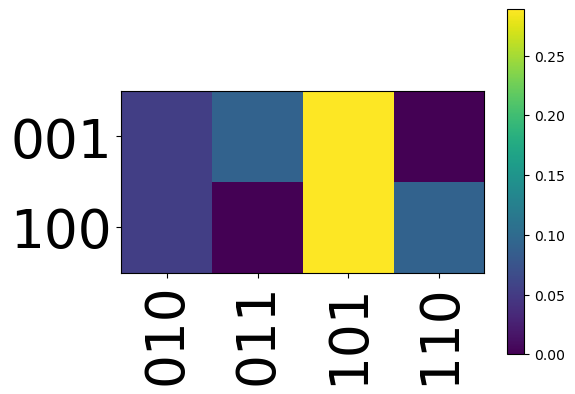

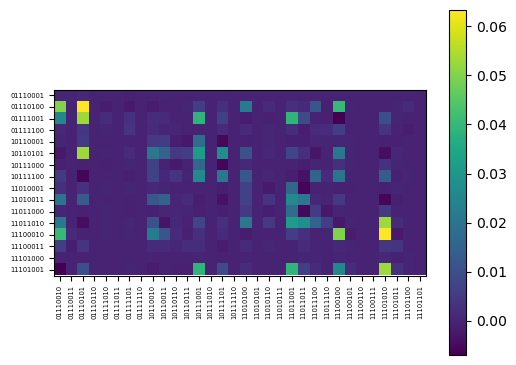

In [17]:
adv.visualize_matrix()
adv_hidden.visualize_matrix()

In [4]:
print(*[[0,1]])

[0, 1]


In [94]:
list(itertools.combinations(range(5), 3))

[(0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 2, 3),
 (0, 2, 4),
 (0, 3, 4),
 (1, 2, 3),
 (1, 2, 4),
 (1, 3, 4),
 (2, 3, 4)]